# ML trials

In [119]:
import pandas as pd
import numpy as np

performance_data = pd.read_csv('performance_data.csv')
submission_template = pd.read_csv('submission_template.csv')
weather_data = pd.read_csv('weather_data.csv')

In [61]:
performance_data.columns

Index(['HYBRID_ID', 'ENV_ID', 'HYBRID_MG', 'ENV_MG', 'YIELD', 'YEAR', 'LAT',
       'LONG', 'PLANT_DATE', 'HARVEST_DATE', 'IRRIGATION', 'ENV_YIELD_MEAN',
       'ENV_YIELD_STD', 'ELEVATION', 'CLAY', 'SILT', 'SAND', 'AWC', 'PH', 'OM',
       'CEC', 'KSAT'],
      dtype='object')

In [62]:
weather_data.head()

,ENV_ID,DAY_NUM,DAYL,PREC,SRAD,SWE,TMAX,TMIN,VP
0,Env_1,1,29030.400391,0,92.800003,24,-14.5,-21.0,120
1,Env_1,2,29030.400391,0,166.399994,24,-7.0,-26.0,80
2,Env_1,3,29030.400391,0,144.000000,24,0.0,-12.5,240
3,Env_1,4,29030.400391,0,112.000000,24,-3.5,-11.5,240
4,Env_1,5,29030.400391,1,153.600006,24,2.5,-11.5,240


## Transforming weather data into useful metrics

In [63]:
weather_data_grouped_mean = weather_data.groupby(by='ENV_ID').mean()
weather_data_grouped_std = weather_data.groupby(by='ENV_ID').std()
weather_data_grouped_mean.head()
weather_data_grouped_std.head()
weather_data_grouped = weather_data_grouped_mean.join(weather_data_grouped_std,
                                                      lsuffix='_AVG',
                                                     rsuffix='_STD')
weather_data_grouped = weather_data_grouped.drop('DAY_NUM_AVG',axis=1)
weather_data_grouped.head()

,DAYL_AVG,PREC_AVG,SRAD_AVG,SWE_AVG,TMAX_AVG,TMIN_AVG,VP_AVG,DAY_NUM_STD,DAYL_STD,PREC_STD,SRAD_STD,SWE_STD,TMAX_STD,TMIN_STD,VP_STD
ENV_ID,,,,,,,,,,,,,,,
Env_1,43200.000043,1.684932,276.111781,11.167123,8.093151,-3.256164,630.356164,105.510663,10075.200862,4.544882,131.085275,16.046875,14.926959,13.574307,535.634711
Env_10,43200.946768,3.079452,294.978630,19.868493,12.095890,2.241096,874.191781,105.510663,8183.382184,5.974924,134.977729,31.810984,11.625704,9.839269,559.526111
Env_100,43200.000070,2.901370,296.714521,20.679452,12.616438,0.632877,820.054795,105.510663,8795.413435,7.152662,119.593751,30.413609,12.877466,12.410814,614.102577
Env_1000,43200.946854,2.000000,352.368219,0.997260,18.323288,2.883562,824.876712,105.510663,6955.702533,6.970897,111.010912,2.447805,11.374718,10.219944,674.104452
Env_1001,43200.946854,2.561644,341.681097,2.443836,17.701370,2.924658,862.246575,105.510663,6955.702533,8.697269,112.386846,5.729262,11.039508,10.119774,629.404388


## Joining performance and weather data

In [213]:
joined_df = performance_data.join(weather_data_grouped,on='ENV_ID')
joined_df.head()
joined_df.columns

heat_stress_df = joined_df[['HYBRID_ID','ENV_ID', 'YIELD', 'TMAX_AVG','TMAX_STD',
                            'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD',
                           'SRAD_AVG','SRAD_STD']]
drought_stress_df = joined_df[['HYBRID_ID','ENV_ID','YIELD','PREC_AVG','PREC_STD','KSAT', #removed 'IRRIGATION
                              'SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']]
#drought_stress_df['IRRIGATION'].unique()
heat_stress_df.head()

,HYBRID_ID,ENV_ID,YIELD,TMAX_AVG,TMAX_STD,TMIN_AVG,TMIN_STD,DAYL_AVG,DAYL_STD,SRAD_AVG,SRAD_STD
0,H2782,Env_1,107.9577,8.093151,14.926959,-3.256164,13.574307,43200.000043,10075.200862,276.111781,131.085275
1,H2782,Env_2,85.7498,8.178082,14.860702,-3.290411,13.446089,43200.000054,10001.326165,278.706849,130.288514
2,H2240,Env_3,74.6116,9.805479,14.311170,-1.224658,12.901740,43200.000054,10001.326165,274.112876,122.067104
3,H1527,Env_3,83.8191,9.805479,14.311170,-1.224658,12.901740,43200.000054,10001.326165,274.112876,122.067104
4,H1369,Env_3,81.7917,9.805479,14.311170,-1.224658,12.901740,43200.000054,10001.326165,274.112876,122.067104


## Decision Tree Regressor
#### Heat stress
#### Drought stress

In [214]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

#heat stress
train_h, test_h = train_test_split(heat_stress_df, test_size = 0.2)
x_train_h = train_h.iloc[:, 3:]
y_train_h = train_h['YIELD']
x_test_h = test_h.iloc[:, 3:]
y_test_h = test_h['YIELD']

#model
model_h = tree.DecisionTreeRegressor(max_depth=20)
model_h.fit(x_train_h,y_train_h)

#model quality
print(f"Training R-Square(Heat Stress): {model_h.score(x_train_h,y_train_h):.4}")
print(f"Testing R-Square(Heat Stress): {model_h.score(x_test_h,y_test_h):.4}")

Training R-Square(Heat Stress): 0.6142
Testing R-Square(Heat Stress): 0.6053


In [215]:
#drought stress
train_d, test_d = train_test_split(drought_stress_df, test_size = 0.2)
x_train_d = train_d.iloc[:, 3:]
y_train_d = train_d['YIELD']
x_test_d = test_d.iloc[:, 3:]
y_test_d = test_d['YIELD']

#model
model_d = tree.DecisionTreeRegressor(max_depth=20)
model_d.fit(x_train_d,y_train_d)

#model quality
print(f"Training R-Square(Drought Stress): {model_d.score(x_train_d,y_train_d):.4}")
print(f"Testing R-Square(Drought Stress): {model_d.score(x_test_d,y_test_d):.4}")

Training R-Square(Drought Stress): 0.6214
Testing R-Square(Drought Stress): 0.6197


In [216]:
heat_stress_df.columns

Index(['HYBRID_ID', 'ENV_ID', 'YIELD', 'TMAX_AVG', 'TMAX_STD', 'TMIN_AVG',
       'TMIN_STD', 'DAYL_AVG', 'DAYL_STD', 'SRAD_AVG', 'SRAD_STD'],
      dtype='object')

#### Feature Importances 

In [217]:
#weights for heat model
test_h_param = ['TMAX_AVG','TMAX_STD', 'TMIN_AVG','TMIN_STD','DAYL_AVG','DAYL_STD', 'SRAD_AVG','SRAD_STD']
weights_h = list(model_d.feature_importances_)
features_h = dict(zip(test_h_param, weights_h))
features_h

{'DAYL_AVG': 0.07076781906931455,
 'DAYL_STD': 0.1419752303918366,
 'SRAD_AVG': 0.22689459600374295,
 'SRAD_STD': 0.08022771075898637,
 'TMAX_AVG': 0.1334852840994806,
 'TMAX_STD': 0.11328643922584683,
 'TMIN_AVG': 0.09318407171013852,
 'TMIN_STD': 0.14017884874065345}

In [103]:
#weights for drought model
test_d_param = ['PREC_AVG','PREC_STD','KSAT','SWE_AVG','SWE_STD','VP_AVG','VP_STD','AWC']
weights_d = list(model_d.feature_importances_)
features_d = dict(zip(test_d_param, weights_d))
features_d

{'AWC': 0.07635892488787693,
 'KSAT': 0.06975530101366316,
 'PREC_AVG': 0.13805741350994546,
 'PREC_STD': 0.13499318190202692,
 'SWE_AVG': 0.1309727228594805,
 'SWE_STD': 0.07857671973574108,
 'VP_AVG': 0.15888379604162034,
 'VP_STD': 0.21240194004964558}

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,0,'Relative Importance')

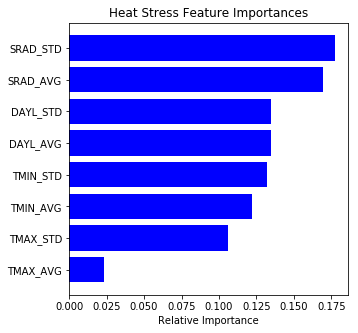

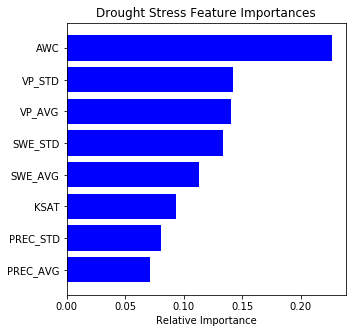

In [218]:
feature_names_h = [key_h for key_h in heat_stress_df.iloc[:,3:]]
#relative importance heat stress
import matplotlib.pyplot as plt
%matplotlib inline
importances = model_h.feature_importances_
indices = np.argsort(importances)
#plt.subplot(1, 1, 1)
plt.figure(figsize=(5,5))
plt.title('Heat Stress Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feature_names_h)
plt.xlabel('Relative Importance')

feature_names_d = [key_d for key_d in drought_stress_df.iloc[:,3:]]
#relative importance drought stress
plt.subplot(1, 1, 1)
importances = model_d.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(5,5))
plt.title('Drought Stress Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)),feature_names_d)
plt.xlabel('Relative Importance')

#### Prediction (heat)

In [234]:
#predicted yield based on heat stress related values

joined_df['predicted_h'] = model_h.predict(joined_df[['TMAX_AVG','TMAX_STD',
                                                      'TMIN_AVG', 'TMIN_STD', 
                                                      'DAYL_AVG','DAYL_STD', 
                                                      'SRAD_AVG','SRAD_STD']])
joined_df['model_h_delta'] = (joined_df['YIELD'] - joined_df['prediction_h'])
divisor_h = 115.96558371559628

joined_df['h_resiliency'] = joined_df['model_h_delta']/ divisor_h
joined_df.head()

,HYBRID_ID,ENV_ID,HYBRID_MG,ENV_MG,YIELD,YEAR,LAT,LONG,PLANT_DATE,HARVEST_DATE,...,TMAX_STD,TMIN_STD,VP_STD,prediction_h,model_h_delta,predicted_d,model_d_delta,d_resiliency,h_resiliency,predicted_h
0,H2782,Env_1,0,0,107.9577,2008,49.5,-98.0,2008-05-06,2008-11-03,...,14.926959,13.574307,535.634711,107.957700,0.000000,107.957700,0.000000,0.000000,0.000000,107.957700
1,H2782,Env_2,0,0,85.7498,2008,49.3,-98.1,2008-05-14,2008-10-22,...,14.860702,13.446089,528.588280,85.749800,0.000000,85.749800,0.000000,0.000000,0.000000,85.749800
2,H2240,Env_3,0,0,74.6116,2011,49.3,-98.0,2011-05-17,2011-10-17,...,14.311170,12.901740,585.217198,81.192375,-6.580775,80.256567,-5.644967,-0.048804,-0.056748,81.192375
3,H1527,Env_3,0,0,83.8191,2011,49.3,-98.0,2011-05-17,2011-10-17,...,14.311170,12.901740,585.217198,81.192375,2.626725,80.256567,3.562533,0.030800,0.022651,81.192375
4,H1369,Env_3,0,0,81.7917,2011,49.3,-98.0,2011-05-17,2011-10-17,...,14.311170,12.901740,585.217198,81.192375,0.599325,80.256567,1.535133,0.013272,0.005168,81.192375


In [247]:
#group by 'HYBRID_ID'
grouped_hybrid = joined_df[['HYBRID_ID', 'YIELD', 'predicted_h',
                           'model_h_delta', 'predicted_d', 'model_d_delta', 
                           'd_resiliency', 'h_resiliency']].groupby('HYBRID_ID').mean()
sorted_g_hybrid = grouped_hybrid.sort_values(['d_resiliency', 'h_resiliency'], ascending=False)

sorted_g_hybrid.head()

,YIELD,predicted_h,model_h_delta,predicted_d,model_d_delta,d_resiliency,h_resiliency
HYBRID_ID,,,,,,,
H3901,147.417817,133.661091,13.756725,133.809836,13.607981,0.117648,0.118628
H1544,141.721321,128.562907,13.158414,128.646520,13.074801,0.113038,0.113468
H3931,150.016557,137.884474,12.132083,137.210777,12.805780,0.110713,0.104618
H4015,146.880695,134.032568,12.848127,134.100973,12.779722,0.110487,0.110793
H2722,124.433900,111.951599,12.482301,111.897094,12.536806,0.108387,0.107638


In [274]:
#create decision tree model with d_resiliency and h_resiliency as x and yield as Y
#linear tree regressor
train_s, test_s = train_test_split(sorted_g_hybrid, test_size = 0.7)
x_train_s = train_s.iloc[:, 5:]
y_train_s = train_s['YIELD']
x_test_s = test_s.iloc[:, 5:]
y_test_s = test_s['YIELD']

#model
model_s = tree.DecisionTreeRegressor(max_depth=20)
model_s.fit(x_train_s,y_train_s)

#model quality
#print(f"Training R-Square(Heat Stress): {model_s.score(x_train_s,y_train_s):.4}")
#print(f"Testing R-Square(Heat Stress): {model_s.score(x_test_s,y_test_s):.4}")


DecisionTreeRegressor(criterion='mse', max_depth=20, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

[0.67948159 0.32051841]


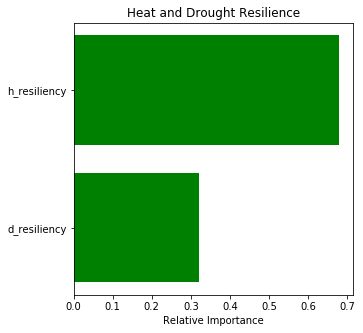

In [275]:
#feature importances - loosely speaking to model quality
feature_names_s = [key_d for key_d in sorted_g_hybrid.iloc[:,5:]]
importances_s = model_s.feature_importances_
indices_s = np.argsort(importances_s)
#create plot
plt.figure(figsize=(5,5))
plt.title('Heat and Drought Resilience')
plt.barh(range(len(indices_s)), importances_s[indices_s], color='g', align='center')
plt.yticks(range(len(indices_s)),feature_names_s)
plt.xlabel('Relative Importance')

print(importances_s)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


count    2452.000000
mean        0.038093
std         0.163992
min        -1.000000
25%        -0.054354
50%         0.048808
75%         0.145309
max         0.543034
Name: resiliency_adj, dtype: float64

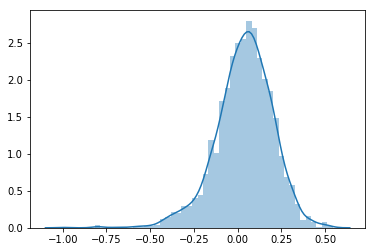

In [337]:
#use the feature importances for the new model to weight and come up with an overall resiliency value for each Hybrid_id
#[0.67948159 0.32051841] are the feature importance rankings for 
h_val = importances_s[0]
d_val = importances_s[1]
#create new combined resiliency column
sorted_g_hybrid['resiliency'] = (sorted_g_hybrid['h_resiliency']*h_val) + (sorted_g_hybrid['d_resiliency']*d_val)

#max(max, abs(min)) = 0.217875
min_ = (sorted_g_hybrid.describe()['resiliency']['min']).astype(float)
max_ = (sorted_g_hybrid.describe()['resiliency']['max']).astype(float)
abs_max = abs(min_)
if abs_max < max_:
    abs_max = max_
#use max abs of resiliency to adjust resiliency into a number between -1 and 1
sorted_g_hybrid['resiliency_adj'] = sorted_g_hybrid['resiliency']/abs_max
sorted_g_hybrid.sort_values('resiliency_adj', ascending = False)
import seaborn as sns

sns.distplot(sorted_g_hybrid[['resiliency_adj']])
(sorted_g_hybrid['resiliency_adj'].describe())

In [231]:

joined_df['predicted_d'] = model_d.predict(joined_df[['PREC_AVG', 
                                                      'PREC_STD','KSAT', 
                                                      'SWE_AVG','SWE_STD', 
                                                      'VP_AVG','VP_STD','AWC']])
joined_df['model_d_delta'] = (joined_df['YIELD'] - joined_df['predicted_d'])
#drought risiliency, divide model_d_delta by max(max, abs(min)) observed delta
divisor_d = 115.666830
joined_df['d_resiliency'] = joined_df['model_d_delta']/ divisor_d
#joined_df['d_resiliency']

In [201]:
# #avg of all heat related column values, difference between that value and value for each row
# #that difference is multiplied by the factor importance value determined from the above ML model
# #divide by the max(abs('heat_stress') so all values are between -1 and 1


# avg = (joined_df.describe()).loc['mean']
# std = (joined_df.describe()).loc['std']
# divisor = 0.8650279601814361
# joined_df['heat_stress'] = ((avg['DAYL_AVG'] - joined_df['DAYL_AVG'])*(-1)*0.07857671973574108 + \
# ((avg['DAYL_STD'] - joined_df['DAYL_STD'])/std['DAYL_STD'])*0.15888379604162034 + \
# ((avg['SRAD_AVG'] - joined_df['SRAD_AVG'])/std['DAYL_STD'])*0.21240194004964558 + \
# ((avg['SRAD_STD'] - joined_df['SRAD_STD'])/std['DAYL_STD'])*0.07635892488787693 + \
# ((avg['TMAX_AVG'] - joined_df['TMAX_AVG'])/std['DAYL_STD'])*0.13805741350994546 + \
# ((avg['TMAX_STD'] - joined_df['TMAX_STD'])/std['DAYL_STD'])*0.13499318190202692 + \
# ((avg['TMIN_AVG'] - joined_df['TMIN_AVG'])/std['DAYL_STD'])*0.06975530101366316 + \
# ((avg['TMIN_STD'] - joined_df['TMIN_STD'])/std['DAYL_STD'])*0.1309727228594805)/divisor

# joined_df.head()




In [ ]:
# 

#### heat and drought stress

In [ ]:
#total heat stress
#for crop level
#difference between predicted heat regression and actual
#difference between predicted drought regression and actual

## Linear Regression (variant threshold analysis)

In [124]:
#ML model
#performance_data
from sklearn.model_selection import train_test_split
train, test = train_test_split(joined_df, test_size = 0.3)
x_train = train.iloc[:, 11:]
y_train = train['YIELD']
x_test = test.iloc[:, 11:]
y_test = test['YIELD']

In [125]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(x_train, y_train)

testing_predictions = model.predict(x_test)

#optiomnal filtering of specific yield predictions
def get_classification(predictions,threshold):
    classes = np.zeros_like(testing_predictions)
    for i in range(len(classes)):
        if predictions[i] > threshold:
            classes[i] = predictions[i]
    return classes

In [126]:
def model_eval(predictions, y_test, test, predict_delta):
    top_hybrids = dict()
    for i in range(len(y_test)):
        temp_hyb = ''
        if int(y_test.iloc[i]) > (int(predictions[i]) + int(predict_delta)):
            temp_hyb = str(test.iloc[i, 0])
            if not temp_hyb in top_hybrids.keys():
                top_hybrids[temp_hyb] = 1
            else:
                top_hybrids[temp_hyb] += 1
    return top_hybrids
#y_test.iloc[0]
len(y_test)
#len(test)
#	HYBRID_ID
model_eval(testing_predictions, y_test, test, 50)

{'H1007': 1,
 'H1009': 2,
 'H1013': 1,
 'H1019': 2,
 'H1037': 3,
 'H1054': 1,
 'H1084': 2,
 'H1117': 3,
 'H1173': 1,
 'H1175': 2,
 'H1183': 1,
 'H1206': 1,
 'H1209': 1,
 'H1228': 2,
 'H1234': 1,
 'H1237': 1,
 'H1258': 1,
 'H1309': 1,
 'H1381': 1,
 'H1466': 1,
 'H1517': 1,
 'H1531': 1,
 'H1704': 1,
 'H1734': 1,
 'H1800': 1,
 'H2340': 1,
 'H2490': 1,
 'H2713': 1,
 'H2909': 1,
 'H2918': 1,
 'H3247': 1}